# Easy 21: A practical Introduction to RL

This resource is intended to be a good place for beginners to get started with RL in a practical way and can be seen as quick summary of the [RL course by David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html).
To obtain more information about the concepts here discussed please check the course!

We'll implement the tasks described at the [Easy 21 assignment](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf).


Special thanks to:
  * David Silver for the great RL course;
  * [AnalogRL implementation's of easy21](https://github.com/analog-rl/Easy21) which had great graphs including the
  gifs you see in this notebook.


> OBS: do you have suggestions? Found something wrong or want to improve some section? Feel free to open an issue or to make a PR :)!

## What will be discussed?

    1. Introduction to RL
       a) What is RL?
       b) Why should I learn RL?
       c) Basic concepts
    2. Learn as you go: solving Easy21 assigment
       a) Implementing the Environment
       b) Monte Carlo Policy Evaluation
       c) Monte Carlo Policy Control
       d) Sarsa lambda Policy Control
       e) Linear Function approximation
    3. What's next?

## 1. Introduction to RL (TODO)


Talk about: Agents, Environment, Policy, How it learns, ...

## 2. Learn as you go: solving Easy21 assigment

**Rules of the [Easy 21 game]([Easy 21 assignment](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf)**

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

### Before get started: Dependencies + Code used for plots

**Dependencies**

First let's import the python libraries needed to run all the code present in this notebook.

In [231]:
'''
Copyright [2017] [Marianne Linhares Monteiro, github: @mari-linhares]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''

# for vectors manipulation
import numpy as np

# for plotting stuff
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# visualize plots in the jupyter notebook
# check more https://goo.gl/U3Ai8R
%matplotlib inline

# for generating random values
import random

# for representing things like card value or colors
from enum import Enum  

# for copying python objects
import copy

**Plot code**

The code below is used to generate the different plots you'll se in the following sections. Don't be
scared if you don't understand the code, no need to understand it at all.

In [232]:
def plot_value_function(agent, title='Value Function', generate_gif=False):
    '''
    Plots a value function as a surface plot, like in: https://goo.gl/aF2doj

    You can choose between just plotting the graph for the value function
    which is the default behaviour (generate_gif=False) or to train the agent
    a couple of times and save the frames in a gif as you train.

    args:
        V (tensor): value function (tensor).
        generate_gif (boolean): if want to save plots as a gif.
        title (string): plot title.
    '''
    # you can change this values to change the size of the graph
    fig = plt.figure(title, figsize=(10, 5))
    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')
    
    V = agent.get_value_function()

    def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
        min_x = 1
        max_x = V.shape[0]
        min_y = 1
        max_y = V.shape[1]

        # creates a sequence from min to max
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # creates a grid representation of x_range and y_range
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        # check documentation for details: https://goo.gl/etEhPP
        ax.set_xlabel('Daler Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)

    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
        if generate_gif:
            print 'Frame:', frame
            i = agent.iterations
            # cool math to increase number of steps as we go
            # this approach generates a cool gif, but feel free to change this value
            step_size = min(max(1, agent.iterations), 2 ** 16)
            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
            # plt.draw()
        else:
            plt.title(title)
        fig.canvas.draw()
        return surf

    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.show()

In [318]:
def plot_error_vs_episode(sqrt_error, lambdas, train_steps=1000000, eval_steps=1000, title='SQRT error VS episode number'):
    '''
        Given the sqrt error between sarsa(lambda) for multiple lambdas and
        an already trained MC control model this function plots a
        graph: sqrt error VS episode number.
        
        Args:
            sqrt_error (tensor): multiD tensor.
            lambdas (tensor): 1D tensor.
            train_steps (int): number the total steps used to train the models.
            eval_steps (int): train_steps/eval_steps is the number of time the
                              errors were calculated while training.
    '''
    # avoid zero division
    assert eval_steps != 0
    x_range = np.arange(0, train_steps, eval_steps)
    
    # assert that the inputs are correct
    assert len(sqrt_error) == len(lambdas)
    for e in sqrt_error:
        assert len(list(x_range)) == len(e)
    
    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)

    for i in xrange(len(sqrt_error)-1, -1, -1):
        ax.plot(x_range, sqrt_error[i], label='lambda %.2f' % lambdas[i])
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [234]:
def plot_error_vs_lambda(sqrt_error, lambdas, title='SQRT error vs lambda'):
    '''
        Given the sqrt error between sarsa(lambda) for multiple lambdas and
        an already trainedMC Control ths function plots a graph:
        sqrt error VS lambda.
        
        Args:
            sqrt_error (tensor): multiD tensor.
            lambdas (tensor): 1D tensor.
        
        The srt_error 1D length must be equal to the lambdas length.
    '''
    
    # assert input is correct
    assert len(sqrt_error) == len(lambdas)
 
    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)
    
    # Y are the last values found at sqrt_error
    y = [s[-1] for s in sqrt_error]
    ax.plot(lambdas, y)
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


### 2. a) Implementing the Environment

Let's implement an environment accordingly to the instructions above. Any agent described in the activity should
be able to interact with this environment for the purposes of this activity.

You should write an environment that implements the game Easy21.

Specifically, write a function, named step, which takes as input a state *s* (dealer’s first card 1–10 and the player’s sum 1–21), and an action *a* (hit or stick), and returns a sample of the next state *s* (which may be terminal if the game is finished) and a reward *r*.


We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1).
You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

#### Deck

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game

In [235]:
class Color(Enum):
    RED = 0
    BLACK = 1


class Card(object):
        
    def __init__(self, color=None):
        self.value = self._get_random_value()
        if color == Color.BLACK or color == Color.RED:
            self.color = color
        else:
            self.color = self._get_random_color()

    def _get_random_value(self):
        '''
            Generates integers between 1 and 10.
        '''
        return random.randint(1, 10)
    
    def _get_random_color(self):
        '''
            Generates random colors.
            Color.RED with 1/3 and Color.BLACK with 2/3 probability.
        '''
        random_number = random.random()
        if random_number <= 1/3.0:
            return Color.RED
        else:
            return Color.BLACK


class Deck(object):  
    def __init__(self):
        return
    
    def take_card(self, color=None):
        return Card(color)

#### State and Action

The state is defined by the dealers first card (which I called *dealer_sum*) and the agent cards (which I called *agent_sum*).

In [236]:
class State(object):
    def __init__(self, dealer_sum=0, agent_sum=0, is_terminal=False):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal


class Action(Enum):
    STICK = 0
    HIT = 1

#### Dealer

* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [237]:
class Player(object):
    '''This is a general class for a player of Easy21.'''
    def __init__(self):
        pass

    def policy(self, s):
        '''Given a state and a deck of cards available choose an action.'''
        return Action.HIT


class Dealer(Player):
    def __init__(self):
        Player.__init__(self)

    def policy(self, s):
        '''Dealers policy as described in the assigment.'''
        if s.dealer_sum >= 17:
            return Action.STICK
        else:
            return Action.HIT

#### Environment (Game)

* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)


In [238]:
class Environment(object):
    '''An environment for the game Easy21.'''
    def __init__(self):
        # the environment includes the dealer and the deck
        self.dealer = Dealer()
        self.deck = Deck()
        
        self.agent_max_value = 21  # max value an agent can get during the game
        self.dealer_max_value = 10  # max value the dealer can get duting the game
        self.actions_count = 2  # number of possible actions
    
    def check_bust(self, player_sum):
        return player_sum <= 1 or player_sum > 21
    
    def generate_reward_bust(self, s):
        if s.agent_sum > s.dealer_sum:
            return 1
        elif s.agent_sum == s.dealer_sum:
            return 0
        else:
            return -1

    def take_card(self, card_color=None):
        '''Returns a card from the deck.'''
        Card = self.deck.take_card(card_color)
        if Card.color == Color.BLACK:
            return Card.value
        else:
            return -1 * Card.value

    def dealer_turn(self, s):
        '''A full implementation of the dealer turn.
        
           The dealer turn starts when the agent sticks and
           ends when the dealer action is busted or action = sticks.
        '''
        action = None
        while not s.is_terminal and action != Action.STICK:
            action = self.dealer.policy(s)
            if action == Action.HIT:
                s.dealer_sum += self.take_card() 
            s.is_terminal = self.check_bust(s.dealer_sum)
        return s
    
    def initial_state(self):
        '''In the beginning both the agent and the dealer take a card.'''
        return State(self.take_card(Color.BLACK), self.take_card(Color.BLACK))

    def step(self, s, a):
        '''
            Given a state and an action return the next state.
            
            Args:
                s (State): current state
                a (Action): action chosen by player
            return:
                next_s (State): next state
                r (Integer): reward [-1, 0, 1]
        '''
        
        # initially there's no reward and the next_s is equal to the
        # current state
        r = 0
        next_s = copy.copy(s)

        # if the player sticks then it's dealer turn
        if a == Action.STICK:
            next_s = self.dealer_turn(s)
            if next_s.is_terminal:
                r = 1
            else:
                next_s.is_terminal = True
                r = self.generate_reward_bust(next_s)       
        else:
            next_s.agent_sum += self.take_card(self.deck)
            next_s.is_terminal = self.check_bust(next_s.agent_sum)

            # if end of the game then player lost: reward = -1
            if next_s.is_terminal:
                r = -1
        
        # print next_s.dealer_sum, next_s.agent_sum, next_s.is_terminal
        return next_s, r

### 2. b) Monte Carlo Policy Evaluation


** General Agent **

Before going into details about Monte Carlo Policy Evaluation, let's implement a General class Agent, this will help us reuse a lot of code and understand better what to expect to see in an agent :).

In [285]:
class Agent(Player):  
    def __init__(self, environment, No=100, discount_factor=1):
        
        Player.__init__(self)
        # easy21 environment
        self.env = environment
        # we can tune these parameters
        self.No = No
        self.disc_factor = discount_factor
        
        # V(s) is the state value function. How good is to be at state s?
        self.V = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])
        
        # this will be used to we keep track of the agent's score
        # score is a simple metric to check if the agent is getting better rewards over time
        # score = (self.wins / self.iterations) * 100 %
        self.wins = 0.0
        self.iterations = 0.0
    
        
    def get_clear_tensor(self):
        '''
            Returns a tensor with zeros with the correct given shape for Q.
            By default this is (max possible dealer sum, max possible agent sum, number of actions)
        '''
        return np.zeros((self.env.dealer_max_value + 1,
                         self.env.agent_max_value + 1, 
                         self.env.actions_count))
        
    def get_alpha(self, st, at):
        '''Size of the step. By what factor should we improve our policy?'''
        return 0.1
    
    def get_e(self, st):
        '''What is the change we will explore over exploit in this state st?'''
        return 0.5

    def get_value_function(self):
        '''Get best value function in the moment.'''
        for i in xrange(1, self.env.dealer_max_value + 1):
            for j in xrange(1, self.env.agent_max_value + 1):
                self.V[i][j] = self.get_max_action(i, j)
        return self.V
    
    def choose_random_action(self):
        return Action.HIT if random.random() <= 0.5 else Action.STICK

    def choose_best_action(self, s):
        '''Returns the best action possible in state s.'''
        return Action.HIT
    
    def get_max_action(self, s):
        '''Returns the max Q(s, a) between all actions.'''
        return 0.0
    
    def policy(self, s):
        '''The policy should return an action.'''
        return self.choose_random_action()

    def get_value_function(self):
        '''Get best value function in the moment.'''
        for i in xrange(1, self.env.dealer_max_value + 1):
            for j in xrange(1, self.env.agent_max_value + 1):
                s = State(i, j)
                self.V[i][j] = self.get_max_action(s)
        return self.V

    def train(self, steps):
        '''Train an agent for a certain number of steps.
        
           Args:
               steps (int): number of episodes to run.
           Returns:
               value function.
        '''
        for e in xrange(steps):
            # do something
            pass
        return self.get_value_function()

** Monte Carlo Evaluation **

In [286]:
class MCAgentEvaluation(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1):
        
        Agent.__init__(self, environment, No, discout_factor)
        
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()
        
        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()
        
        # G_s(s) is the sum of all returns we got using this state
        self.G_s = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])
  
    def get_e(self, s):
        '''et = N0/(N0 + N(st))'''
        return self.No/((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))

    def get_value_function(self):
        return self.V
    
    def predict(self, episode):
        '''Given an episode. Improve the value function approximation.'''
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            Gt = sum([x[2]*(self.disc_factor**i) for i,x in enumerate(episode[j:])])
            self.G_s[d_sum][a_sum] += Gt
            self.V[d_sum][a_sum] = self.G_s[d_sum][a_sum] / sum(self.N[s.dealer_sum, s.agent_sum, :])
    
    def policy(self, s):
        if s.agent_sum >= 17:
            action = Action.STICK
        else:
            action = Action.HIT
        
        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action
    
    def train(self, steps):
        for e in xrange(steps):
            episode = []
            
            # get initial state for current episode
            s = self.env.initial_state()
            
            # while game has not ended
            while not s.is_terminal:
                
                # get action with epsilon greedy policy
                a = self.policy(s)
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
                
                # store action state and reward
                episode.append((s, a, r))
                
                # update state
                s = next_s

            if e % 10000 == 0 and self.iterations > 0:
                print "Episode: %d, score: %f" % (e, (float(self.wins)/(self.iterations)*100.0))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1
                
            # Update Action value function accordingly
            self.predict(episode) 

        return self.get_value_function()

Episode: 10000, score: 33.720000
Episode: 20000, score: 33.555000
Episode: 30000, score: 32.963333
Episode: 40000, score: 33.065000
Episode: 50000, score: 33.126000
Episode: 60000, score: 33.081667
Episode: 70000, score: 33.057143
Episode: 80000, score: 33.116250
Episode: 90000, score: 33.072222


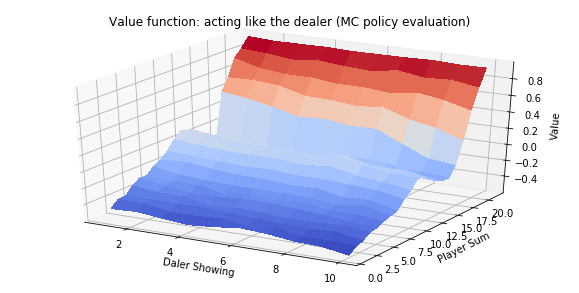

In [267]:
TRAIN_STEPS = 100000

environment = Environment()
agent = MCAgentEvaluation(environment)

agent.train(TRAIN_STEPS)

plot_value_function(agent, title='Value function: acting like the dealer (MC policy evaluation)')

### 2. c) Monte Carlo Policy Control

In [292]:
class MCAgentControl(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1):
        
        Agent.__init__(self, environment, No, discount_factor)
        
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()
        
        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()
        
    def get_alpha(self, s, a):
        '''αt = 1/N(st, at)'''
        return 1.0/(self.N[s.dealer_sum][s.agent_sum][a.value])
    
    def get_e(self, s):
        '''et = N0/(N0 + N(st))'''
        return self.No/((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))
    
    def get_max_action(self, s):
        return np.max(self.Q[s.dealer_sum][s.agent_sum])
    
    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK

    def predict(self, episode):
        '''Given an episode. Improve the value function approximation.'''
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            
            Gt = sum([x[2]*(self.disc_factor**i) for i,x in enumerate(episode[j:])])
            
            error = Gt - self.Q[d_sum][a_sum][a.value]
            self.Q[d_sum][a_sum][a.value] += self.get_alpha(s, a) * error
            j += 1
            
    def policy(self, s):
        r = random.random()
        #print r, self.get_e(s)
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)

        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action
    
    def train(self, steps):
        for e in xrange(steps):
            episode = []
            
            # get initial state for current episode
            s = self.env.initial_state()
            
            # while game has not ended
            while not s.is_terminal:
                
                # get action with epsilon greedy policy
                a = self.policy(s)
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
                
                # store action state and reward
                episode.append((s, a, r))
                
                # update state
                s = next_s

            if e % 10000 == 0 and self.iterations > 0:
                print "Episode: %d, score: %f" % (e, (float(self.wins)/(self.iterations)*100.0))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1
                
            # Update Action value function accordingly
            self.predict(episode) 

        return self.get_value_function()

Episode: 10000, score: 48.720000
Episode: 20000, score: 50.300000
Episode: 30000, score: 51.076667
Episode: 40000, score: 51.595000
Episode: 50000, score: 51.864000
Episode: 60000, score: 52.240000
Episode: 70000, score: 52.455714
Episode: 80000, score: 52.613750
Episode: 90000, score: 52.810000


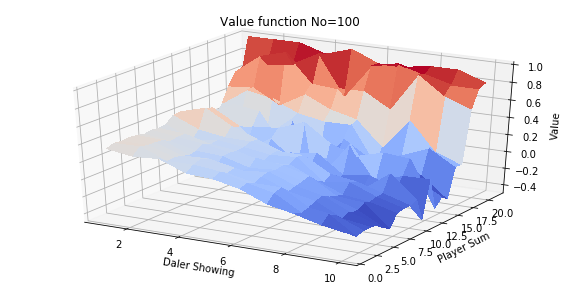

In [290]:
TRAIN_STEPS = 100000

environment = Environment()
agent = MCAgentControl(environment)

agent.train(TRAIN_STEPS)

plot_value_function(agent, title="Value function No=100")

Episode: 0, score: 0
Episode: 0, score: 0
Episode: 0, score: 25
Episode: 0, score: 37
Episode: 0, score: 37
Episode: 0, score: 40
Episode: 0, score: 48
Episode: 0, score: 50
Episode: 0, score: 48
Episode: 0, score: 47
Episode: 0, score: 47
Episode: 0, score: 45
Episode: 0, score: 46
Episode: 0, score: 45
Episode: 0, score: 45
Episode: 10000, score: 45
Episode: 0, score: 45
Episode: 10000, score: 45
Episode: 20000, score: 46
Episode: 30000, score: 46
Episode: 0, score: 46
Episode: 10000, score: 46
Episode: 20000, score: 46
Episode: 30000, score: 46
Episode: 40000, score: 46
Episode: 50000, score: 46
Episode: 60000, score: 46
Episode: 0, score: 46
Episode: 10000, score: 46
Episode: 20000, score: 46
Episode: 30000, score: 46
Episode: 40000, score: 46
Episode: 50000, score: 46
Episode: 60000, score: 46
Episode: 0, score: 46
Episode: 10000, score: 46
Episode: 20000, score: 47
Episode: 30000, score: 47
Episode: 40000, score: 47
Episode: 50000, score: 47
Episode: 60000, score: 47
Episode: 0, 

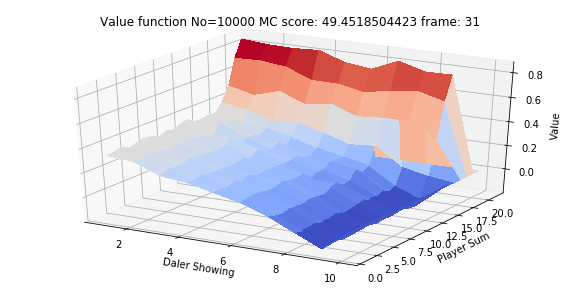

In [60]:
environment = Environment()
agent = MCAgentControl(environment, No=10000)

plot_value_function(agent, generate_gif=True, title="Value function No=10000")

### 2. d) Sarsa lambda Policy Control

In [296]:
class SarsaAgent(MCAgentControl):
    
    def __init__(self, environment, No=100, discount_factor=1, _lambda=1):
        
        MCAgentControl.__init__(self, environment, No, discount_factor)
      
        # we can tune this parameter
        self._lambda = _lambda
        
        # Eligibility Trace
        self.E = self.get_clear_tensor()
    
    def get_q(self, s, a):
        return self.Q[s.dealer_sum][s.agent_sum][a.value]
 
    def train(self, steps):
        for e in xrange(steps):
            # clear eligibility trace
            self.E = self.get_clear_tensor()
            
            # get initial state for current episode
            s = self.env.initial_state()

            # choose a from s with epsilon greedy policy
            a = self.policy(s)
            next_a = a 
            
            # while game has not ended
            while not s.is_terminal:
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
              
                q = self.get_q(s, a)
                
                if not next_s.is_terminal:
                    # choose next action with epsilon greedy policy
                    next_a = self.policy(next_s)
                    q_next = self.get_q(next_s, next_a)
                    delta = r + q_next - q
                else:
                    delta = r - q 
            
                self.E[s.dealer_sum][s.agent_sum][a.value] += 1
                alpha = self.get_alpha(s, a)
                update_q = alpha * delta * self.E
                self.Q += update_q
                self.E *= (self.disc_factor * self._lambda)
                
                # update state and action
                s = next_s
                a = next_a

            if e % 100000 == 0 and e != 0:
                print "Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100)
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1

        # Derive value function
        return self.get_value_function()

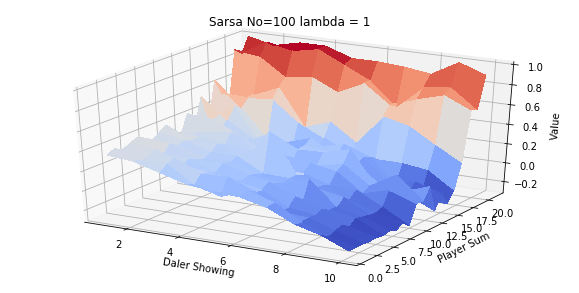

In [297]:
TRAIN_STEPS = 100000

environment = Environment()
agent = SarsaAgent(environment)

agent.train(TRAIN_STEPS)

plot_value_function(agent, title="Sarsa No=100 lambda = 1")

Episode: 10000, score: 45.310000
Episode: 20000, score: 45.245000
Episode: 30000, score: 45.473333
Episode: 40000, score: 45.457500
Episode: 50000, score: 45.556000
Episode: 60000, score: 45.665000
Episode: 70000, score: 45.785714
Episode: 80000, score: 45.996250
Episode: 90000, score: 46.003333


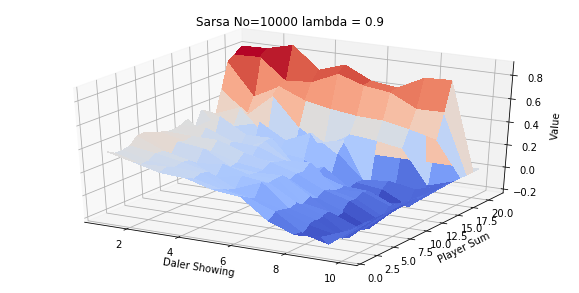

In [74]:
environment = Environment()
agent = Sarsa_agent(environment, _lambda=0.9, No=10000)

agent.train(TRAIN_STEPS)

plot_value_function(agent, title="Sarsa No=10000 lambda = 0.9")

#### Mean Squared Error

In [75]:
TRAIN_STEPS = 1000000
mc_agent = MC_agent(environment)
mc_agent.train(TRAIN_STEPS)

Episode: 10000, score: 48.230000
Episode: 20000, score: 49.725000
Episode: 30000, score: 50.956667
Episode: 40000, score: 51.432500
Episode: 50000, score: 51.670000
Episode: 60000, score: 51.816667
Episode: 70000, score: 52.125714
Episode: 80000, score: 52.262500
Episode: 90000, score: 52.384444
Episode: 100000, score: 52.573000
Episode: 110000, score: 52.775455
Episode: 120000, score: 52.900000
Episode: 130000, score: 53.021538
Episode: 140000, score: 53.164286
Episode: 150000, score: 53.242667
Episode: 160000, score: 53.350625
Episode: 170000, score: 53.455294
Episode: 180000, score: 53.539444
Episode: 190000, score: 53.607895
Episode: 200000, score: 53.641000
Episode: 210000, score: 53.670952
Episode: 220000, score: 53.710000
Episode: 230000, score: 53.701304
Episode: 240000, score: 53.759583
Episode: 250000, score: 53.754800
Episode: 260000, score: 53.755769
Episode: 270000, score: 53.762593
Episode: 280000, score: 53.797143
Episode: 290000, score: 53.835862
Episode: 300000, score:

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   3.54370915e-01,   3.61363404e-01,
          3.48090188e-01,   3.38741144e-01,   3.43353783e-01,
          3.48702595e-01,   3.51868460e-01,   3.34292763e-01,
          3.57516139e-01,   3.42062525e-01,   3.52112676e-01,
          4.00000000e-01,   4.13043478e-01,   1.14754098e-01,
          2.09876543e-01,  -1.69491525e-02,   5.09433962e-01,
          5.25000000e-01,   8.33333333e-01,   8.62068966e-01,
          0.00000000e+00],
       [  0.00000000e+00,   3.10661765e-01,   3.13558452e-01,
          3.0556

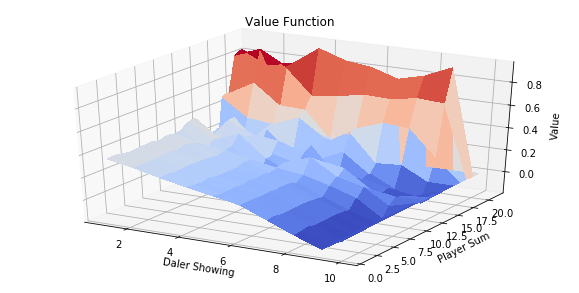

In [76]:
plot_value_function(mc_agent)

In [303]:
lambdas = [e/10.0 for e in range(0, 11, 1)]
print 'lambdas:', lambdas

lambdas: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [314]:
def mean_sqr(q1, q2):
    return np.sum(np.square(q1-q2))

TRAIN_STEPS = 100000
EVAL_STEPS = 1000
errors = []
for i, l in enumerate(lambdas):
    print 'Training Sarsa(%f)' % l
    errors.append([])
    sarsa_agent = SarsaAgent(environment, _lambda=l)
    for j in xrange(TRAIN_STEPS/EVAL_STEPS):
        sarsa_agent.train(EVAL_STEPS)
        errors[i].append(mean_sqr(mc_agent.Q.q, sarsa_agent.Q))

Training Sarsa(0.000000)
Training Sarsa(0.100000)
Training Sarsa(0.200000)
Training Sarsa(0.300000)
Training Sarsa(0.400000)
Training Sarsa(0.500000)
Training Sarsa(0.600000)
Training Sarsa(0.700000)
Training Sarsa(0.800000)
Training Sarsa(0.900000)
Training Sarsa(1.000000)


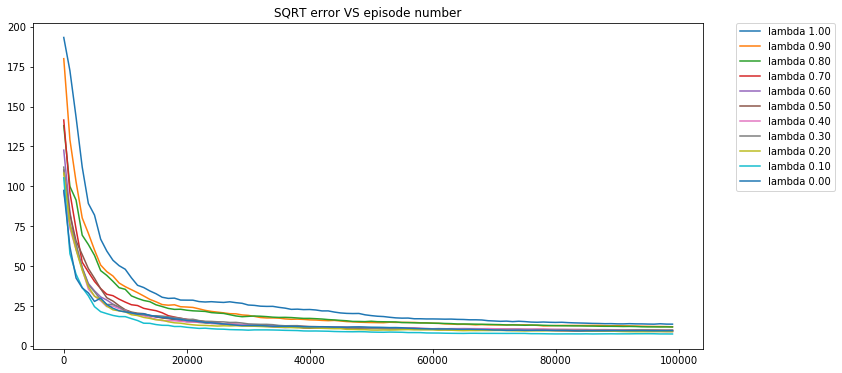

In [320]:
plot_error_vs_episode(errors, lambdas, train_steps=TRAIN_STEPS, eval_steps=EVAL_STEPS)

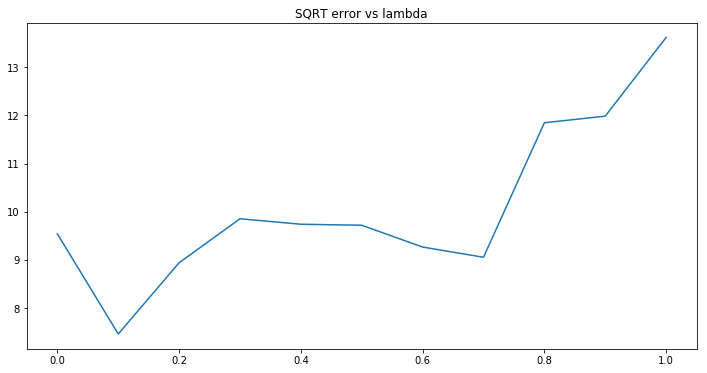

In [321]:
plot_error_vs_lambda(errors, lambdas)

### 2. e) Linear Function approximation

In [362]:
class LinearFunctionSarsaAgent(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1, _lambda=1):    
        Agent.__init__(self, environment, No, discount_factor)
        
        # we can tune these parameters
        self._lambda = _lambda
        self.number_of_parameters = 36
        
        # parameters are initialize randomly
        self.theta = np.random.randn(self.number_of_parameters) * 0.1
        
        # eligibility trace
        self.E = self.get_clear_tensor()
  
        # features
        self.dealer_features = [[1, 4], [4, 7], [7, 10]]
        self.agent_features = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
    
    def get_clear_tensor(self):
        '''
            Returns a tensor with zeros with the correct shape.
        '''
        return np.zeros(self.number_of_parameters)

    def get_q(self, s, a):
        return np.dot(self.phi(s, a), self.theta)
    
    def get_all_q(self):
        q = np.zeros((self.env.dealer_max_value + 1,
                         self.env.agent_max_value + 1, 
                         self.env.actions_count))
        
        for i in xrange(1, self.env.dealer_max_value + 1):
            for j in xrange(1, self.env.agent_max_value + 1):
                for a in [Action.HIT, Action.STICK]:
                    s = State(i, j)
                    q[i, j, a.value] = self.get_q(s, a)
    
        return q
    def phi(self, s, a):
        d_sum = s.dealer_sum
        a_sum = s.agent_sum
        
        features = np.zeros((3, 6, 2), dtype=np.int)
        
        d_features = np.array([x[0] <= d_sum <= x[1] for x in self.dealer_features])
        a_features = np.array([x[0] <= a_sum <= x[1] for x in self.agent_features])
        
        for i in np.where(d_features):
            for j in np.where(a_features):
                features[i, j, a.value] = 1

        return features.flatten()
   
    def get_alpha(self, s, a):
        return 0.01
       
    def get_e(self, s):
        return 0.05

    def try_all_actions(self, s):
        return [np.dot(self.phi(s, Action.STICK), self.theta), np.dot(self.phi(s, Action.HIT), self.theta)]
    
    def get_max_action(self, s):
        return np.max(self.try_all_actions(s))
    
    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.try_all_actions(s)) == 1 else Action.STICK
    
    def policy(self, s):
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)

        return action

    def train(self, steps):
        for e in xrange(steps):
            # clear eligibility trace
            self.E = self.get_clear_tensor()
            
            # get initial state for current episode
            s = self.env.initial_state()

            # choose a from s with epsilon greedy policy
            a = self.policy(s)
            next_a = a 
                 
            # while game has not ended
            while not s.is_terminal:
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
              
                # get parameters that represent this state and action
                phi = self.phi(s, a)
                # get q(s, a)
                q = self.get_q(s, a)
                
                if not next_s.is_terminal:
                    # choose next action with epsilon greedy policy
                    next_a = self.policy(next_s)
                    q_next = self.get_q(next_s, next_a)
                    delta = r + q_next - q
                else:
                    delta = r - q 
            
                self.E += phi
                alpha = self.get_alpha(s, a)
                update_q = alpha * delta * self.E
                self.theta += update_q
                self.E *= (self.disc_factor * self._lambda)
                
                # update state and action
                s = next_s
                a = next_a

            if e % 10000 == 0 and e != 0:
                print "Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100)
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1

        return self.get_value_function()

In [351]:
TRAIN_STEPS = 100000
sarsa_agent = LinearFunctionSarsaAgent(environment)
sarsa_agent.train(TRAIN_STEPS)

KeyboardInterrupt: 

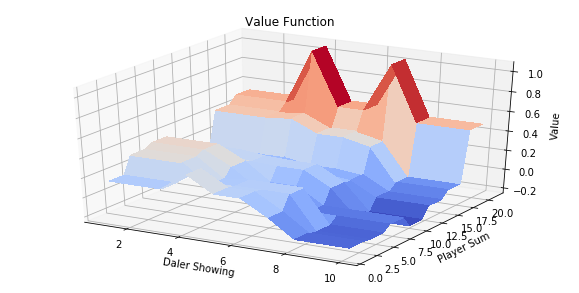

In [340]:
plot_value_function(sarsa_agent)

In [363]:
def mean_sqr(q1, q2):
    return np.sum(np.square(q1-q2))

EVAL_STEPS = 1000
TEST_STEPS = 10000
error = []
for i, l in enumerate(lambdas):
    print 'Training Sarsa(%f)' % l
    error.append([])
    sarsa_agent = LinearFunctionSarsaAgent(environment, _lambda=l)
    for j in xrange(TRAIN_STEPS/EVAL_STEPS):
        sarsa_agent.train(TRAIN_STEPS/EVAL_STEPS)
        error[i].append(mean_sqr(mc_agent.Q.q, sarsa_agent.get_all_q()))

Training Sarsa(0.000000)
Training Sarsa(0.100000)
Training Sarsa(0.200000)
Training Sarsa(0.300000)
Training Sarsa(0.400000)
Training Sarsa(0.500000)
Training Sarsa(0.600000)
Training Sarsa(0.700000)
Training Sarsa(0.800000)
Training Sarsa(0.900000)
Training Sarsa(1.000000)
[[56.640582593472175, 52.438823206726468, 51.330710850396784, 50.206258568484913, 49.909484773947838, 46.251163800077208, 45.728389999437496, 44.862781491805116, 43.163705903050598, 42.259610789770612, 41.367877561872881, 42.499881697360827, 41.867920517774671, 41.989609289946905, 40.970427296791279, 39.748102102391172, 38.683638249163067, 38.850806094778804, 38.397231681633102, 38.687881549771092, 37.979519267326005, 38.135382729670241, 38.167263704281972, 38.168551944065065, 37.967801979220411, 37.2679499549116, 37.030821193590924, 36.873532975734598, 36.556054303925485, 36.210207552713676, 36.322553638108545, 36.10163596779293, 36.045887008234686, 36.052174107347142, 36.233663231413587, 36.687344811609108, 35.961

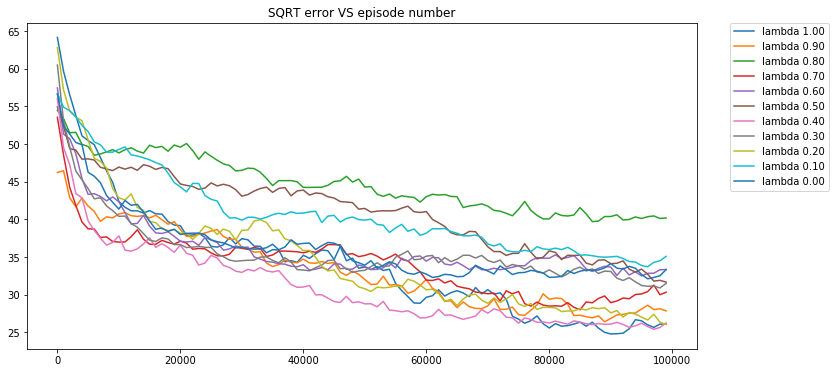

In [364]:
plot_lambdas(error, lambdas)

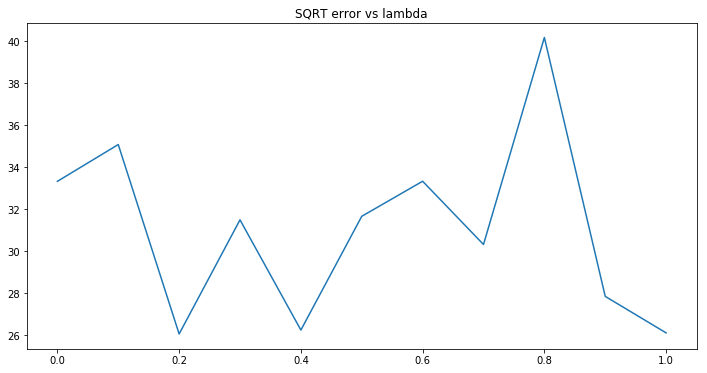

In [365]:
plot_final_lambda(error, lambdas)